# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

<span style="color:gray">The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).</span>

<span style="color:gray">The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**.</span>

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import random
seed=0
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

2025-01-24 15:40:21.414361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:40:21.414756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 15:40:21.417364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 15:40:21.426343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 15:40:21.439686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

#### Step 1: Load and Process the Data

<span style="color:gray">Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.</span>

<span style="color:gray">The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.</span>

<span style="color:gray">Once we have loaded the data, we need to format it in the correct shape.</span>

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

<span style="color:gray">Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.</span>

In [3]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 9


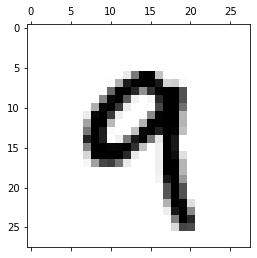

... and with label [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[110])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[110,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[110], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

<span style="color:gray">We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method</span>

<span style="color:gray">For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.</span>

<span style="color:gray">In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.</span>

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

<span style="color:gray">Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:</span>

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

<span style="color:gray">We train our DNN in minibatches.</span>

<span style="color:gray">Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.</span>

<span style="color:gray">Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`.</span>

In [7]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

/home/lorenzo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737729623.584394  157497 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-24 15:40:23.587499: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
S

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - acc: 0.6413 - loss: 1.1707 - val_acc: 0.9138 - val_loss: 0.3119
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.8819 - loss: 0.4141 - val_acc: 0.9311 - val_loss: 0.2381
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9074 - loss: 0.3237 - val_acc: 0.9425 - val_loss: 0.1984
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9219 - loss: 0.2750 - val_acc: 0.9495 - val_loss: 0.1723
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9310 - loss: 0.2435 - val_acc: 0.9545 - val_loss: 0.1560


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

<span style="color:gray">Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.</span>

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - acc: 0.9463 - loss: 0.1838

Test loss: 0.15598365664482117
Test accuracy: 0.9545000195503235


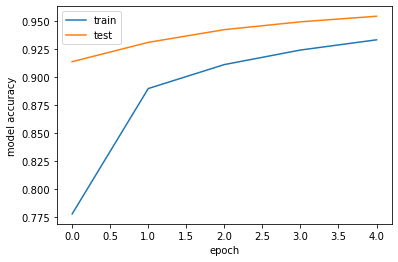

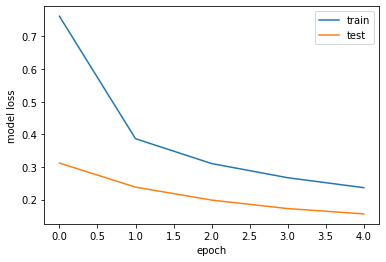

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

<span style="color:gray">Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.</span>

<span style="color:gray">Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.</span>

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


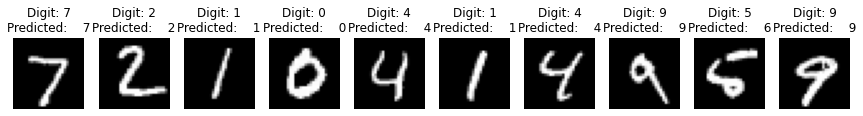

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test_plot = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test_plot[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value.</span> <span style="color:gray">Try to use at least two other optimizers, different from SGD:</span> <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

### Solution:

Let's try 50 epoch with the Adam optimizer:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - acc: 0.9788 - loss: 0.2253

Test loss: 0.17088806629180908
Test accuracy: 0.9829999804496765


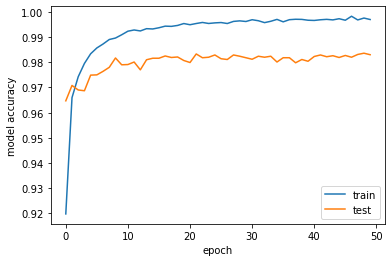

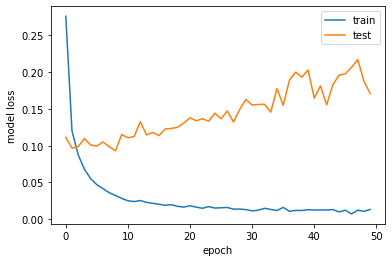

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


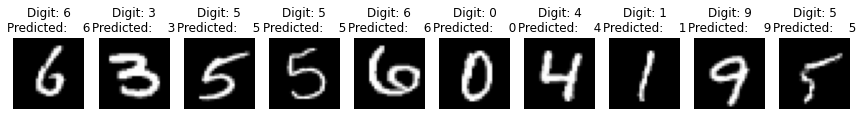

In [10]:
def compile_model(opty=0):
    # create the model
    options = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=options[opty],
                  metrics=['acc'])
    return model

model_DNN = compile_model(1)

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=0,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test_plot = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test_plot[i+50, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[50+i]), np.argmax(predictions[50+i])))    
    plt.axis('off') 
plt.show()

The accuracy improved from $\approx$ 95% to $\approx$ 98%, but the loss increased slightly. The testing accuracy is still better than the training accuracy for the first few epochs, but then the situation reverses. Accuracy plateaus after some 20 epochs.

Let's see if we can get similar values of accuracy with a smaller number of epochs, then! In the next run, I used the Nadam optimizer and 20 epochs:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - acc: 0.9793 - loss: 0.1470

Test loss: 0.11737756431102753
Test accuracy: 0.9825999736785889


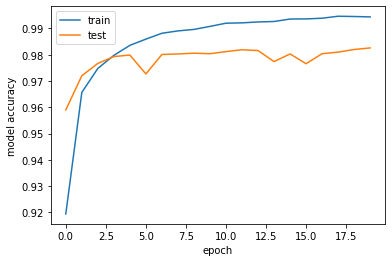

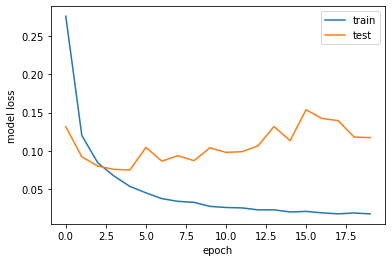

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


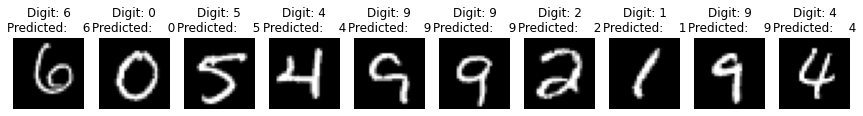

In [11]:
model_DNN = compile_model(6)

history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=0,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test_plot = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test_plot[i+100, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[100+i]), np.argmax(predictions[100+i])))    
    plt.axis('off') 
plt.show()

The accuracy is still around 98% but the loss is definetly lower. Comparing the graphs, it is apparent that Adam and Nadam behave similarly for this kind of problem, which is not surprising considering they are similar algorithms.

#### Creating Convolutional Neural Nets with Keras

<span style="color:gray">We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows</span>

In [12]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_cnn = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train_cnn shape:', X_train_cnn.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train_cnn.shape[0], 'train samples')
print(X_test_cnn.shape[0], 'test samples')

X_train_cnn shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


<span style="color:gray">One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.</span>

### Exercise 12.2

<span style="color:gray"> Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that </span> **<span style="color:red">you should complete</span>**:

### Solution:

I completed the `create_CNN()` function using the following structure:

* The first layer is a convolutional layer with kernel size (5, 5)
* The second layer is a pooling layer with size (5, 5), no strides and no padding
* The third layer is a droput layer 
* The fourth layer is a dense layer with tanh as the activation function
* The fifth layer is flat
* The last layer is a soft-max layer

In [13]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(5, 5),
                           strides=None, 
                           padding='valid'))
    model.add(Dropout(0.3))
    model.add(Dense(400, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['acc'])
    return model

<span style="color:gray">Train your DCNN and evaluate its performance proceeding exactly as before:</span>

I used a batch_size of 32 (seemed reasonable) and 20 epochs (as suggested by the previous DNN effort):

/home/lorenzo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(5, 5, 1, 10)
Filters:


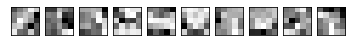

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9768 - loss: 0.0736

Test loss: 0.06253913044929504
Test accuracy: 0.9807999730110168


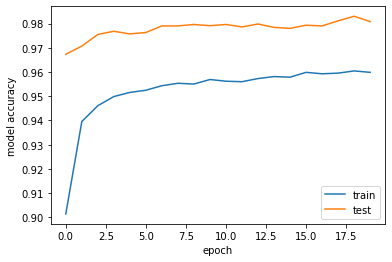

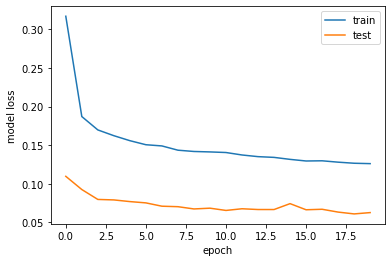

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


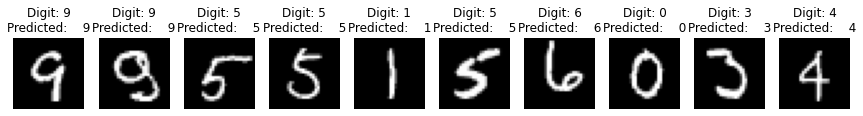

In [14]:
# training parameters
batch_size = 32
epochs = 20 # INSERT HERE AN ADEQUATE NUMBER OF EPOCHS!

# create the deep conv net
model_CNN=create_CNN()

# train CNN
CNN_history = model_CNN.fit(X_train_cnn, Y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_data=(X_test_cnn, Y_test))

#display filters
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
print("Filters:")
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

# evaluate model
score = model_CNN.evaluate(X_test_cnn, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(CNN_history.history['acc'])
plt.plot(CNN_history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test_cnn)

X_test_plot = X_test_cnn.reshape(X_test_cnn.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test_plot[i+150, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[150+i]), np.argmax(predictions[150+i])))    
    plt.axis('off') 
plt.show()

<span style="color:gray">In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.</span>

At the end of the day, my CNN has a performance more or less similar to my DNN (accuracy is $\approx$ 98%), but it needs less time to get there (it plateaus after only a few epochs)

### Exercise 12.3

<span style="color:gray">Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.</span>

<span style="color:gray">For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):</span>

Image size: 28x28


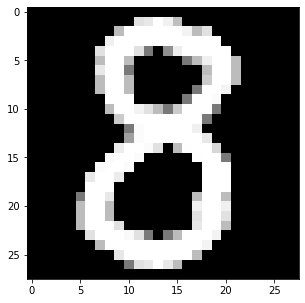

(28, 28)


In [15]:
from PIL import Image
import os

digit_in = list()
for index in range(0,10):
    digit_filename = "./digits/" + str(index) + ".png"
    digit_in.append(Image.open(digit_filename).convert('L'))

data = list()
ydim, xdim = list(), list()
for index in range(0,10):
    y, x = digit_in[index].size
    ydim.append(y)
    xdim.append(x)
    pix=digit_in[index].load();
    data.append(np.zeros((x, y)))
    for j in range(y):
        for i in range(x):
            data[index][i,j]=pix[j,i]
    data[index] /= 255

print("Image size: "+str(xdim[8])+"x"+str(ydim[8]))

plt.figure(figsize=(5,5))
plt.imshow(data[8], cmap='gray')
plt.show()

print(data[0].shape)

<span style="color:gray">I use the previously trained DNN to predict the digit:</span>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


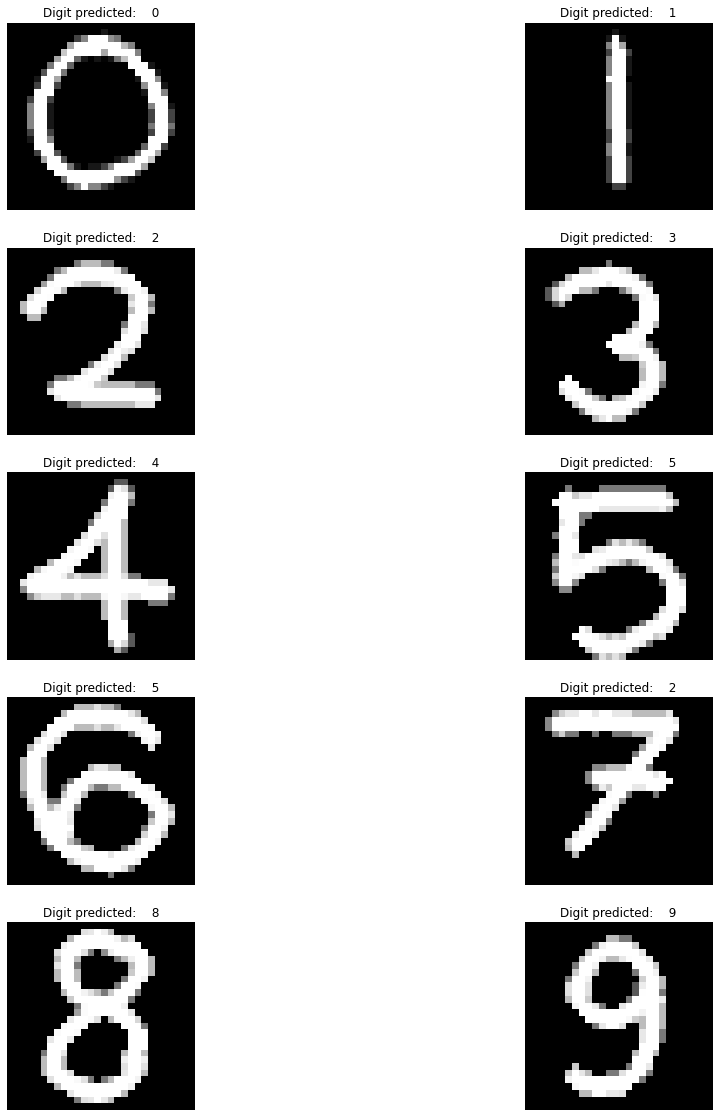

In [16]:
fig, axs = plt.subplots(5, 2, figsize=(17,20))
for ax, row in zip(axs, [0,1,2,3,4]):
    for a, column in zip(ax, [0,1]):
        data[2*row + column] = data[2*row + column].reshape(1,xdim[2*row + column]*ydim[2*row + column])
        pred_0 = model_DNN.predict(data[2*row + column])
        data[2*row + column] = data[2*row + column].reshape(xdim[2*row + column],ydim[2*row + column])
        a.imshow(data[2*row + column], cmap='gray')
        a.set_title("Digit predicted:    {}".format(np.argmax(pred_0)))
        a.axis('off') 

plt.show()

The DNN predicts correctly all the digits except for 6 and 7 (which are interpreted respectively as 5 and 2). I repeated the test with the CNN:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


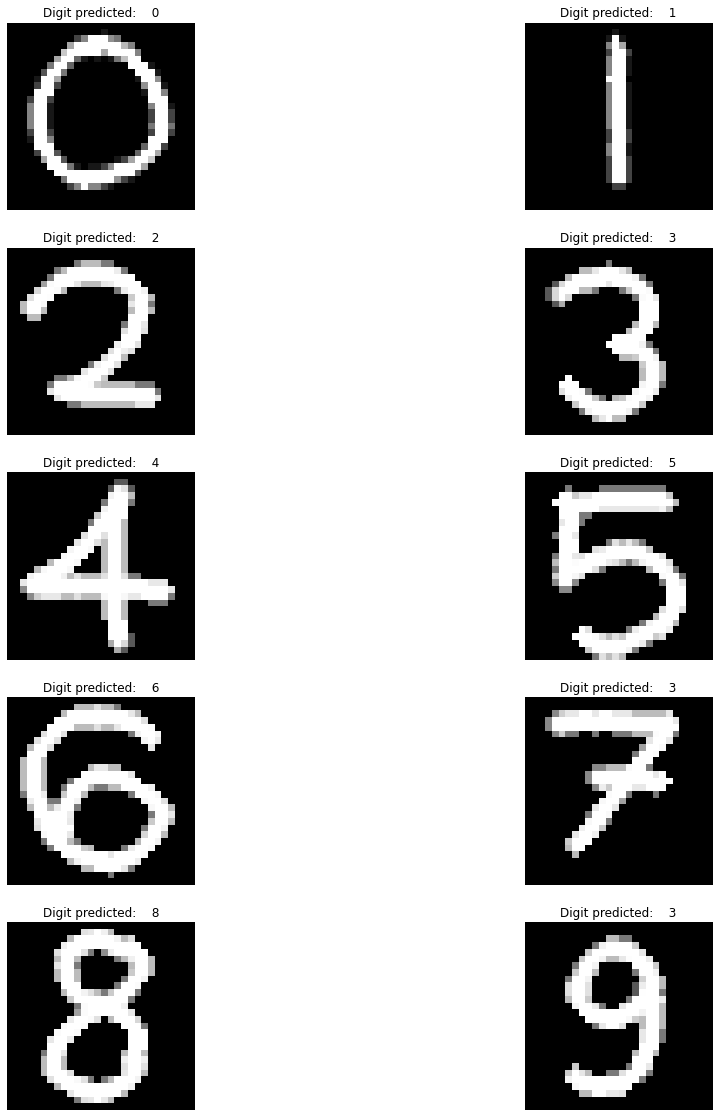

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(17,20))
for ax, row in zip(axs, [0,1,2,3,4]):
    for a, column in zip(ax, [0,1]):
        if keras.backend.image_data_format() == 'channels_first':
            data[2*row + column] = data[2*row + column].reshape(1, 1, xdim[2*row + column], ydim[2*row + column])
        else:
            data[2*row + column] = data[2*row + column].reshape(1, xdim[2*row + column], ydim[2*row + column], 1)
        pred_1 = model_CNN.predict(data[2*row + column])
        data[2*row + column] = data[2*row + column].reshape(xdim[2*row + column], ydim[2*row + column])
        a.imshow(data[2*row + column], cmap='gray')
        a.set_title("Digit predicted:    {}".format(np.argmax(pred_1)))
        a.axis('off') 

plt.show()

Which works for 8 digits out of 10, with the sole exceptions being 7 (which is interpreted as a 3) and 9 (which again is interpreted as a 3).